In [29]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats
import ncar_jobqueue
from dask.distributed import Client

#### Define CESM case and get the years of data that we'll average over

### 2xGCB case 

In [30]:
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.004/ocn/proc/mean5thIAF/mean_IAF5_alk_dic.nc'
#ds2xGCB.to_netcdf(outfile)

In [31]:
ds2xGCB=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [32]:
ds2xGCB

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT          (nlat, nlon) float64 ...
    TLONG        (nlat, nlon) float64 ...
    dz           (z_t) float32 ...
    TAREA        (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 ...
    REGION_MASK  (nlat, nlon) float64 ...
    ALK_ALT_CO2  (z_t, nlat, nlon) float32 ...
    ALK          (z_t, nlat, nlon) float32 ...
    DIC          (z_t, nlat, nlon) float32 ...
    DIC_ALT_CO2  (z_t, nlat, nlon) float32 ...

### GET noGCB ALK and DIC

In [33]:
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/mean_IAF5_alk_dic.nc'
#dsnoGCB.to_netcdf(outfile)

In [34]:
dsnoGCB=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [35]:
dsnoGCB

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    REGION_MASK  (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 ...
    TLONG        (nlat, nlon) float64 ...
    dz           (z_t) float32 ...
    TAREA        (nlat, nlon) float64 ...
    KMT          (nlat, nlon) float64 ...
    ALK_ALT_CO2  (z_t, nlat, nlon) float32 ...
    ALK          (z_t, nlat, nlon) float32 ...
    DIC          (z_t, nlat, nlon) float32 ...
    DIC_ALT_CO2  (z_t, nlat, nlon) float32 ...

### DIC and ALK over top 50m

In [43]:
DIC_control = dsnoGCB.DIC.isel(z_t=slice(0,1)).mean(dim='z_t')
ALK_control = dsnoGCB.ALK.isel(z_t=slice(0,1)).mean(dim='z_t')

In [44]:
DIC_noGCB = dsnoGCB.DIC_ALT_CO2.isel(z_t=slice(0,1)).mean(dim='z_t')
ALK_noGCB = dsnoGCB.ALK_ALT_CO2.isel(z_t=slice(0,1)).mean(dim='z_t')

In [45]:
DIC_2xGCB = ds2xGCB.DIC_ALT_CO2.isel(z_t=slice(0,1)).mean(dim='z_t')
ALK_2xGCB = ds2xGCB.ALK_ALT_CO2.isel(z_t=slice(0,1)).mean(dim='z_t')

In [46]:
Revelle_control = (3*ALK_control*DIC_control - 2*DIC_control*DIC_control)/((2*DIC_control-ALK_control)*(ALK_control-DIC_control))

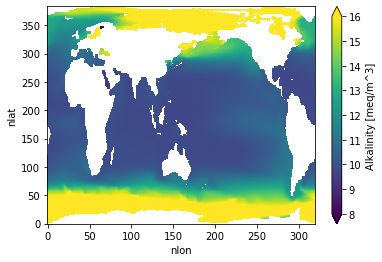

In [47]:
Revelle_control.plot(vmin=8,vmax=16)

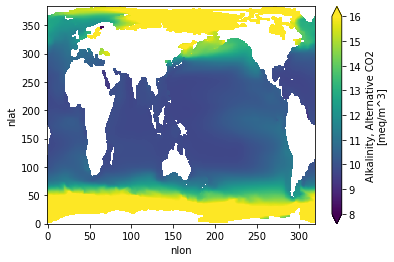

In [48]:
Revelle_noGCB = (3*ALK_noGCB*DIC_noGCB - 2*DIC_noGCB*DIC_noGCB)/((2*DIC_noGCB-ALK_noGCB)*(ALK_noGCB-DIC_noGCB))
Revelle_noGCB.plot(vmin=8,vmax=16)

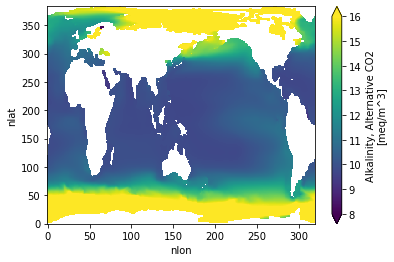

In [49]:
Revelle_2xGCB = (3*ALK_2xGCB*DIC_2xGCB - 2*DIC_2xGCB*DIC_2xGCB)/((2*DIC_2xGCB-ALK_2xGCB)*(ALK_2xGCB-DIC_2xGCB))
Revelle_2xGCB.plot(vmin=8,vmax=16)

### Get Potential density

In [50]:
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.004/ocn/proc/mean5thIAF/mean_IAF5_alk_pd004.nc'
ds_pd=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [51]:
sigma_surf=ds_pd.PD.isel(z_t=0) * 1000. -1000.

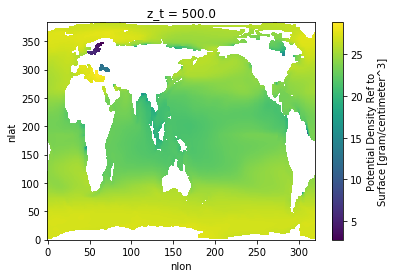

In [52]:
sigma_surf.plot()

In [53]:
sigma_50m=ds_pd.PD.isel(z_t=slice(0,5)).mean(dim='z_t') * 1000. -1000.

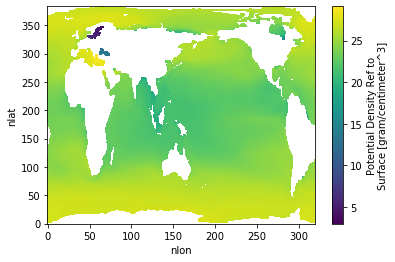

In [54]:
sigma_50m.plot()

In [55]:
sigma_100m=ds_pd.PD.isel(z_t=slice(0,10)).mean(dim='z_t') * 1000. -1000.

### Define a few plotting functions

In [56]:
def canvas_map_contour_overlay(lon,lat,z,
                               contour_specs,
                               units,
                               fig,
                               gridspec,
                               row,col):
    #-- make masked
    z = np.ma.masked_invalid(z)
    
    #-- make canvas
    ax = fig.add_subplot(gridspec[row,col],projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_global()

    #-- make filled contours
    cf = ax.contourf(lon,lat,z,
                     transform=ccrs.PlateCarree(),
                     **contour_specs)
    #-- rasterize
    zorder = 0
    for contour_level in cf.collections:
        contour_level.set_zorder(zorder)
        contour_level.set_rasterized(True)

    #-- add contour lines
    cs = ax.contour(lon,lat,z,
                    colors='k',
                    levels = contour_specs['levels'],
                    linewidths = 0.5,
                    transform=ccrs.PlateCarree(),
                    zorder=len(cf.collections)+10)
    fmt = '%r'
    #-- add contour labels
    lb = plt.clabel(cs, fontsize=8,
                   inline = True,
                   fmt=fmt)

    #-- add land mask
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='face',
                                            facecolor='black'))

    #-- add colorbar
    i = 0
    while True:
        i += 1
        try:
            gridspec[i]
        except:
            break
    len_gs = i
    if len_gs == 1:
        shrink_factor = 0.75
    else:
        shrink_factor = 0.75

    cb = fig.colorbar(cf,ax = ax,
                      ticks = contour_specs['levels'],
                      orientation = 'vertical',
                      shrink = shrink_factor)
    cb.ax.set_title(units)
    cb.ax.tick_params(labelsize=9) 

    return {'ax':ax,'cf':cf,'cs':cs,'lb':lb,'cb':cb}

In [57]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

#### Define plotting coords with WOA on POP grid
#### (doesn't have the nans in the coords)

In [58]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = dsnoGCB.z_t

In [59]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

#### Plot by depth

In [60]:
Revelle_noGCB_diff = Revelle_noGCB - Revelle_control
Revelle_2xGCB_diff = Revelle_2xGCB - Revelle_control

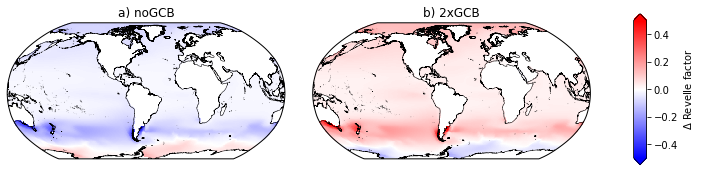

In [61]:
fig = plt.figure(figsize=(12,3))

######### Revelle for noGCB
lon,lat,field=adjust_pop_grid(lons, lats, Revelle_noGCB_diff)
ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) noGCB', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.5, vmax=0.5,transform=ccrs.PlateCarree())


######### Revelle for 2x GCB
lon,lat,field=adjust_pop_grid(lons, lats, Revelle_2xGCB_diff)
ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) 2xGCB', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.5, vmax=0.5,transform=ccrs.PlateCarree())





fig.subplots_adjust(right=0.8,hspace=0,wspace=0.1)
cbar_ax = fig.add_axes([0.85, 0.16, 0.015, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='$\Delta$ Revelle factor',extend='both')

fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/Revelle_diffmaps.png', bbox_inches='tight', format='png', dpi=600);

### With sigma outcrops

In [68]:
contour_specs = {'levels': [25.4,25.8,26.2,26.6,27.0,27.2,27.4]}
contour_specs = {'levels': [27.1]}

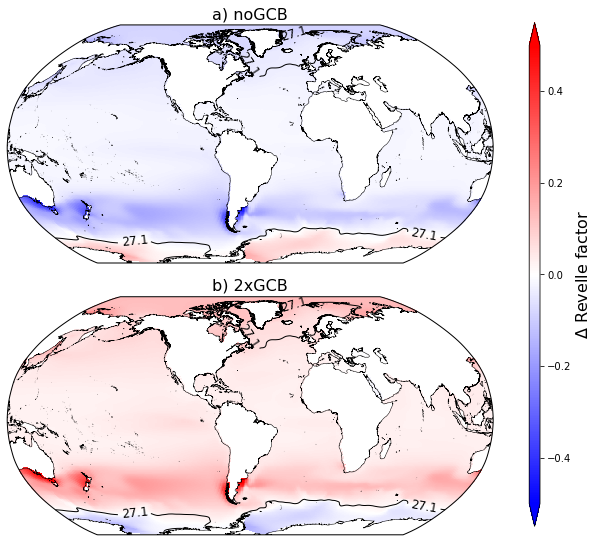

In [75]:
fig = plt.figure(figsize=(10,10))

lon,lat,pd_field=adjust_pop_grid(lons, lats, sigma_100m)

######### Revelle for noGCB
lon,lat,field=adjust_pop_grid(lons, lats, Revelle_noGCB_diff)
ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) noGCB', fontsize=16)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.5, vmax=0.5,transform=ccrs.PlateCarree())
cs = ax.contour(lon,lat,pd_field,
                colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'black', fmt = '%2.1f', fontsize=12)

######### Revelle for 2x GCB
lon,lat,field=adjust_pop_grid(lons, lats, Revelle_2xGCB_diff)
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) 2xGCB', fontsize=16)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.5, vmax=0.5,transform=ccrs.PlateCarree())

cs = ax.contour(lon,lat,pd_field,
                colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'black', fmt = '%2.1f', fontsize=12)


fig.subplots_adjust(right=0.8,hspace=0,wspace=0.1)
cbar_ax = fig.add_axes([0.85, 0.16, 0.015, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,extend='both')
cbar.set_label('$\Delta$ Revelle factor', fontsize=16)
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/Revelle_diffmaps.png', bbox_inches='tight', format='png', dpi=600);